In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.75G/1.76G [00:17<00:00, 130MB/s]
100% 1.76G/1.76G [00:17<00:00, 110MB/s]


In [ ]:
!unzip /content/lung-and-colon-cancer-histopathological-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008.jpeg  
  inflating: lung_c

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
import PIL as Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot  as plt
from sklearn.model_selection  import   train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow  as tf
from tensorflow import  keras
from tensorflow.keras.models import  Sequential
\
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam ,Adamax ,AdamW
from tensorflow.keras.layers import Conv2D ,MaxPooling2D,Flatten,Dense ,Activation, Dropout,BatchNormalization
from tensorflow.keras import regularizers

In [ ]:
data_dir="/content/lung_colon_image_set"
filepaths = []
labels = []
folds=os.listdir(data_dir)
for fold in folds:
    foldpath= os.path.join(data_dir, fold)
    flist=os.listdir(foldpath)
    for f in flist:
        f_path=os.path.join(foldpath, f)
        filelist=os.listdir(f_path)
        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)
            if f=="colon_aca" :
                labels.append("Colon Adenocarcinoma")
            elif f == "colon_n":
                labels.append("Colon Benign Tissue")
            elif f=="lung_aca":
                labels.append("Lung Adenocarcinoma")
            elif f == "lung_n":
                labels.append("Lung Benign Tissue")
            elif f=="lung_scc":
                labels.append("Lung Squamous Cell Carcinoma")

Fseries= pd.Series(filepaths ,name= "file_paths")
Lseries =pd.Series(labels ,name ="Labels")
df= pd.concat ([Fseries ,Lseries],axis =1)
df

,file_paths,Labels
0,/content/lung_colon_image_set/lung_image_sets/...,Lung Squamous Cell Carcinoma
1,/content/lung_colon_image_set/lung_image_sets/...,Lung Squamous Cell Carcinoma
2,/content/lung_colon_image_set/lung_image_sets/...,Lung Squamous Cell Carcinoma
3,/content/lung_colon_image_set/lung_image_sets/...,Lung Squamous Cell Carcinoma
4,/content/lung_colon_image_set/lung_image_sets/...,Lung Squamous Cell Carcinoma
...,...,...
24995,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
24996,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
24997,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
24998,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma


In [ ]:
strat =df["Labels"]

train_df ,dummy_df = train_test_split(df ,train_size= 0.8,shuffle=True , random_state =123 ,stratify =strat )

strat=dummy_df["Labels"]
valid_df,test_df = train_test_split(dummy_df ,train_size=0.5,shuffle =True , random_state =123,stratify =strat )

In [ ]:
batch_size =64
img_size=(224,224)
channels=3
img_shape=(224 ,224 ,3)

tre_gen =ImageDataGenerator()
ts_gen =ImageDataGenerator()

train_gen = tre_gen.flow_from_dataframe(train_df , x_col = 'file_paths' , y_col = 'Labels' , target_size = img_size ,
                                   class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size = 64)
valid_gen = tre_gen.flow_from_dataframe(valid_df , x_col = 'file_paths' , y_col = 'Labels' , target_size = img_size ,
                                   class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size = 64)
test_gen= tre_gen.flow_from_dataframe(test_df , x_col = 'file_paths' , y_col = 'Labels' , target_size = img_size ,
                                   class_mode = 'categorical' , color_mode = 'rgb' , shuffle = False , batch_size = 64)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [ ]:
img_size = (224,224)
channels = 3
img_shape = (224,224,3)
class_count = 5

model = tf.keras.Sequential([Conv2D(filters =64 , kernel_size=(3,3) , padding ="same" ,activation="relu" ,input_shape= img_shape ),
Conv2D(filters =64 , kernel_size=(3,3) , padding = "same" , activation ="relu"),
MaxPooling2D((2,2)),

Conv2D(filters =128 , kernel_size=(3,3) , padding ="same" ,activation="relu" ),
Conv2D(filters =128, kernel_size=(3,3) , padding = "same" , activation ="relu"),
Conv2D(filters =128, kernel_size=(3,3) , padding = "same" , activation ="relu"),
MaxPooling2D((2,2)),

Conv2D(filters =256, kernel_size=(3,3) , padding ="same" ,activation="relu" ),
Conv2D(filters =256, kernel_size=(3,3) , padding = "same" , activation ="relu"),
Conv2D(filters =256, kernel_size=(3,3) , padding = "same" , activation ="relu"),
MaxPooling2D((2,2)),

Conv2D(filters =512 , kernel_size=(3,3) , padding ="same" ,activation="relu" ),
Conv2D(filters =512, kernel_size=(3,3) , padding = "same" , activation ="relu"),
Conv2D(filters =512, kernel_size=(3,3) , padding = "same" , activation ="relu"),
MaxPooling2D((2,2)),

Conv2D(filters =512 , kernel_size= (3,3) , padding ="same" ,activation="relu" ),
Conv2D(filters =512, kernel_size=(3,3) , padding = "same" , activation ="relu"),
Conv2D(filters =512, kernel_size=(3,3) , padding = "same" , activation ="relu"),
MaxPooling2D((2,2)),

Flatten(),
Dense(256 ,activation= "relu"),
Dense(64 ,activation="relu"),
Dense(256, activation ="relu"),
Dense(64 , activation = "relu"),
Dense(64,activation ="relu"),
Dense(class_count , activation="softmax")])

model.compile(Adamax(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
epochs =20
history = model.fit(x=train_gen ,epochs= epochs , verbose= 1, validation_data = valid_gen ,validation_steps =None , shuffle =False)

Epoch 1/20
313/313 [==============================] - 329s 951ms/step - loss: 0.6887 - accuracy: 0.6813 - val_loss: 0.4408 - val_accuracy: 0.8072
Epoch 2/20
313/313 [==============================] - 295s 943ms/step - loss: 0.4159 - accuracy: 0.8271 - val_loss: 0.5079 - val_accuracy: 0.8128
Epoch 3/20
313/313 [==============================] - 289s 923ms/step - loss: 0.3223 - accuracy: 0.8727 - val_loss: 0.2712 - val_accuracy: 0.8996
Epoch 4/20
313/313 [==============================] - 291s 929ms/step - loss: 0.2536 - accuracy: 0.9014 - val_loss: 0.2883 - val_accuracy: 0.8884
Epoch 5/20
313/313 [==============================] - 297s 949ms/step - loss: 0.2022 - accuracy: 0.9229 - val_loss: 0.1709 - val_accuracy: 0.9332
Epoch 6/20
313/313 [==============================] - 291s 929ms/step - loss: 0.1701 - accuracy: 0.9341 - val_loss: 0.2352 - val_accuracy: 0.9132
Epoch 7/20
313/313 [==============================] - 291s 929ms/step - loss: 0.1407 - accuracy: 0.9456 - val_loss: 0.1597 -

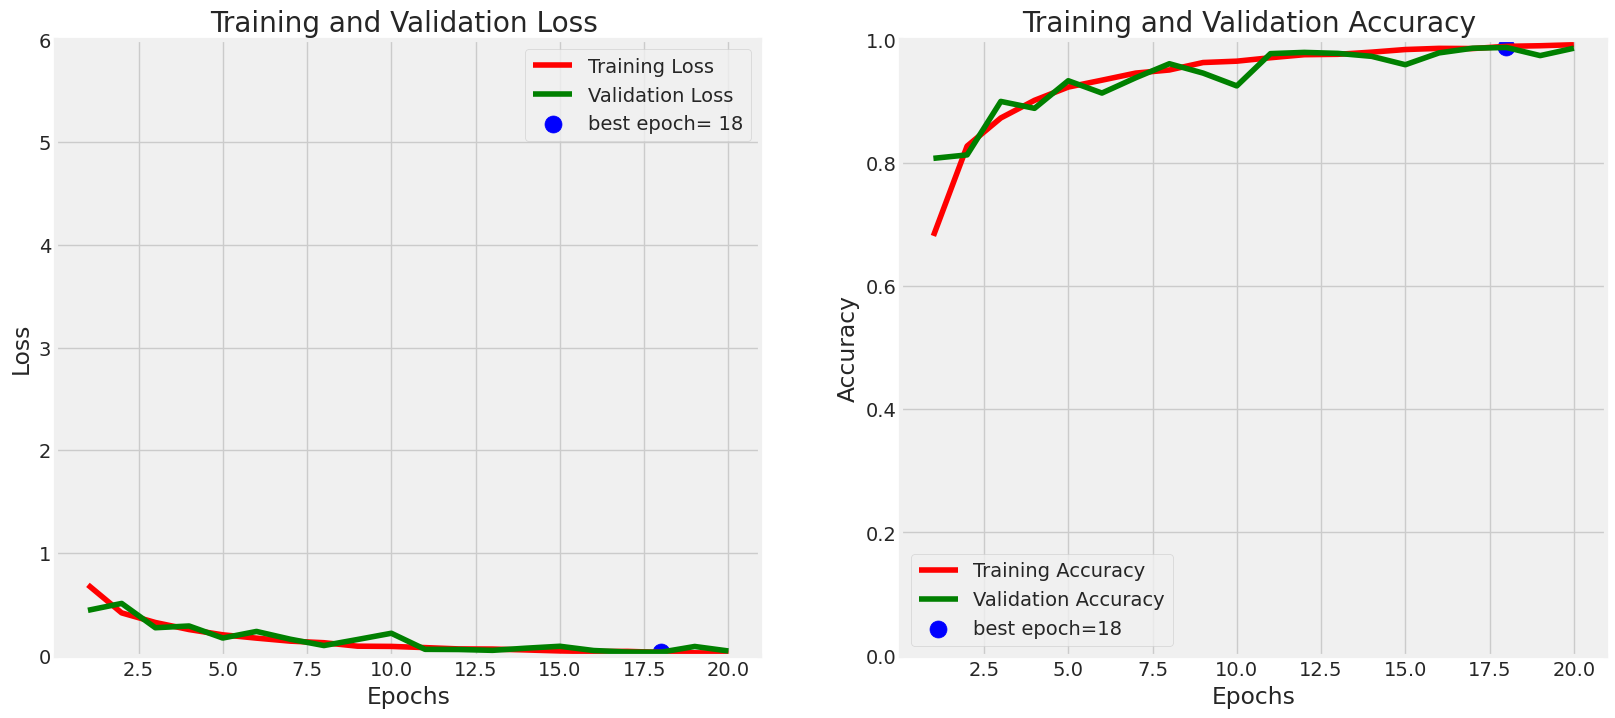

In [ ]:
tr_acc = history.history["accuracy"]
tr_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest =val_acc[index_acc]
Epochs = [i+1 for i in range (len(tr_acc))]
loss_label = f"best epoch= {str(index_loss+1)}"
acc_label = f"best epoch={str(index_acc+1)}"

plt.figure(figsize =(20,8))
plt.style.use("fivethirtyeight")

plt.subplot(1,2,1)
plt.plot(Epochs ,tr_loss ,'r',label = "Training Loss")
plt.plot(Epochs , val_loss ,'g',label="Validation Loss")
plt.scatter(index_loss+1 ,val_lowest , s=150 ,c= "blue",label = loss_label)
plt.title("Training and Validation Loss ")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0,6)
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs ,tr_acc ,'r',label = "Training Accuracy")
plt.plot(Epochs , val_acc ,'g',label="Validation Accuracy")
plt.scatter(index_acc+1 ,acc_highest , s=150 ,c= "blue",label = acc_label)
plt.title("Training and Validation Accuracy ")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length= len(test_df)
test_batch_size =max(sorted([ts_length//n for n in range (1, ts_length +1)if ts_length%n == 0 and ts_length/n <=80]))
test_steps =ts_length // test_batch_size

train_score =model.evaluate(train_gen ,steps= test_steps , verbose =1 )
valid_score =model.evaluate(valid_gen ,steps= test_steps , verbose =1 )
test_score =model.evaluate(test_gen ,steps= test_steps , verbose =1 )

print("Train Loss:" , train_score[0])
print("Traing Accuracy :",train_score[1])
print("-"*20)

print("Valid Loss:" , valid_score[0])
print("Valid Accuracy :", valid_score[1])
print("-"*20)

print("Test Loss:" , test_score[0])
print("Test Accuracy :",test_score[1])

39/50 [======================>.......] - ETA: 3s - loss: 0.0449 - accuracy: 0.9860

39/50 [======================>.......] - ETA: 3s - loss: 0.0449 - accuracy: 0.9848

50/50 [==============================] - 14s 273ms/step - loss: 0.0449 - accuracy: 0.9848
Train Loss: 0.014202190563082695
Traing Accuracy : 0.995312511920929
--------------------
Valid Loss: 0.04481300711631775
Valid Accuracy : 0.9860000014305115
--------------------
Test Loss: 0.04486691579222679
Test Accuracy : 0.9847999811172485


In [ ]:
preds=model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis=1 )

<ipython-input-16-ce6c73d3b9f7>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds=model.predict_generator(test_gen)


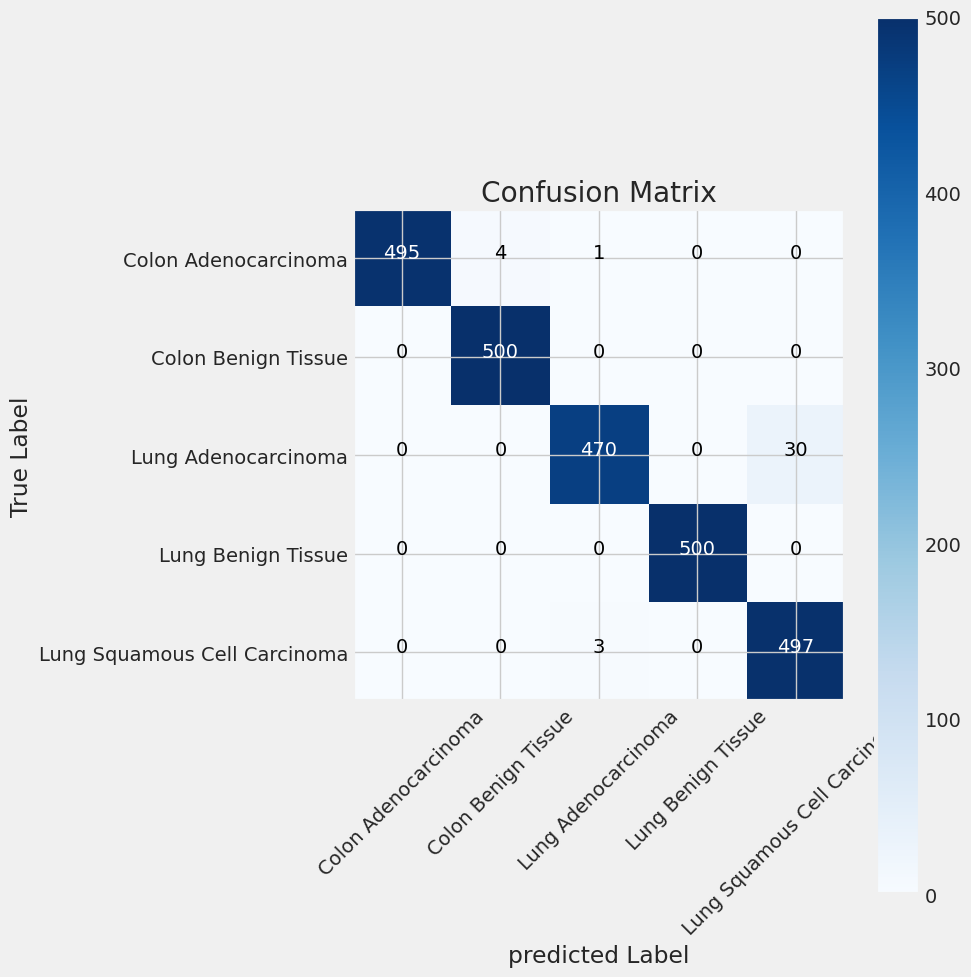

In [ ]:
g_dict =test_gen.class_indices
classes=list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10,10))
plt.imshow(cm,interpolation="nearest",cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks =np.arange(len(classes))
plt.xticks(tick_marks, classes ,rotation =45)
plt.yticks(tick_marks ,classes)

thresh =cm.max()/2
for i ,j in itertools.product (range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],horizontalalignment = "center",color = "white" if cm[i,j]>thresh else "black")

    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("predicted Label")

    plt.show

In [ ]:
print(classification_report(test_gen.classes ,y_pred , target_names=classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       1.00      0.99      0.99       500
         Colon Benign Tissue       0.99      1.00      1.00       500
         Lung Adenocarcinoma       0.99      0.94      0.97       500
          Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cell Carcinoma       0.94      0.99      0.97       500

                    accuracy                           0.98      2500
                   macro avg       0.99      0.98      0.98      2500
                weighted avg       0.99      0.98      0.98      2500



In [ ]:
model.save("/content/Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
! cp /content/Model.h5 /content/drive/MyDrive